## 1. Import necessary packages

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

## 2. Start Unity Environment

In [4]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 3. Initialize brain 

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 4. Inspect State and Action Space

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 5. DDPQ Algorithm

In [16]:
def ddpg(n_episodes=3000, max_t=1000):
    
    avg_score = []
    chkpt_episodes = 100
    scores_deque = deque(maxlen=100)
    num_update = 10
    len_agents = len(str(num_agents))
    
    agent  = Agent(state_size, action_size, random_seed = 2)
    agent_params = {"state_size": state_size, "action_size": action_size, "random_seed": 2,}
    agents = [Agent(**agent_params) for _ in range(num_agents)]
    
    env_solv = False
    
    assert len(agents) == num_agents
    
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.save_exp_in_replay(states, actions, rewards, next_states, dones)

            if t%num_update == 0:
                    agent.step(states, actions, rewards, next_states, dones)
            states  = next_states
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = np.max(scores)        
        avg_score.append(score)
        scores_deque.append(score)

        avg = np.average(scores_deque)
            
        # bookkeeping and printing the learning process    
        print('\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, avg), end="")
        
        
        
        
        if i_episode % chkpt_episodes == 0:
            
            if not env_solv and avg >= 0.5:
                print("\r\rsolved in episode {i_episode}, w/ avg_score={avg:.2f}\r".format(i_episode=i_episode, avg=avg))
                env_solv = True
                # finish once environment is solved
                break
            
            print("\n")
            print("\rEPISODE: {i_episode}\t Average Score: {avg:.2f} \tTotal Score: {total:.2f}".format(i_episode=i_episode, avg=avg,total=np.sum(scores_deque)))

            for idx, agent in enumerate(agents):
                chkpt_path_actor = "actor_" + str(idx).zfill(len_agents) + ".pth"
                torch.save(agent.actor_local.state_dict(), chkpt_path_actor)

                chkpt_path_critic = "critic_" + str(idx).zfill(len_agents) + ".pth"
                torch.save(agent.critic_local.state_dict(), chkpt_path_critic)

    return avg_score

## 6. Run the Training

In [17]:
scores = ddpg()

Episode 100	Episode Score: 0.00	Average Score: 0.00

EPISODE: 100	 Average Score: 0.00 	Total Score: 0.00
Episode 200	Episode Score: 0.00	Average Score: 0.00

EPISODE: 200	 Average Score: 0.00 	Total Score: 0.48
Episode 300	Episode Score: 0.00	Average Score: 0.00

EPISODE: 300	 Average Score: 0.00 	Total Score: 0.29
Episode 400	Episode Score: 0.00	Average Score: 0.00

EPISODE: 400	 Average Score: 0.00 	Total Score: 0.28
Episode 500	Episode Score: 0.10	Average Score: 0.01

EPISODE: 500	 Average Score: 0.01 	Total Score: 0.87
Episode 600	Episode Score: 0.09	Average Score: 0.01

EPISODE: 600	 Average Score: 0.01 	Total Score: 1.19
Episode 700	Episode Score: 0.00	Average Score: 0.05

EPISODE: 700	 Average Score: 0.05 	Total Score: 4.70
Episode 800	Episode Score: 0.10	Average Score: 0.05

EPISODE: 800	 Average Score: 0.05 	Total Score: 5.10
Episode 900	Episode Score: 0.10	Average Score: 0.09

EPISODE: 900	 Average Score: 0.09 	Total Score: 9.28
Episode 1000	Episode Score: 0.00	Average Score

## 7. Plot the Training Process

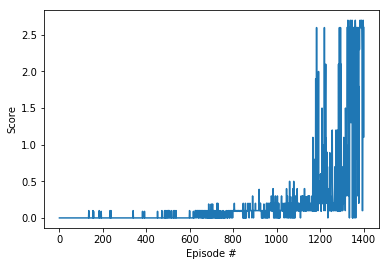

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 8. Close the environment

In [19]:
env.close()